# Chapter 12 Inheritance: For Good or For Worse (1)

## 내장 자료형 상속
Python 2.2 이후부터 `list`나 `dict`와 같은 기본 제공 자료형의 상속이 가능해졌지만, "사용자 정의 클래스에서 override한 special method는 호출되지 않는다"는 점을 주의해서 사용해야한다. 

In [1]:
class DoppelDict(dict):
    def __setitem__(self, key, value):
        super().__setitem__(key, [value] * 2)

dd = DoppelDict(one=1)
dd

{'one': 1}

In [2]:
dd['two'] = 2
dd

{'one': 1, 'two': [2, 2]}

In [3]:
dd.update(three=3)
dd

{'one': 1, 'two': [2, 2], 'three': 3}

즉, override 된 내용을 무시한다. 이러한 현상은 method 탐색은 항상 타겟 인스턴스의 클래스에서부터 시작해야한다(호출이 부모 클래스 내의 method에서 일어났다고 하더라도)는 객체지향 프로그래밍의 규칙에 어긋난다.  
이러한 문제는 인스턴스 내에서의 호출에 제한되지 않고 다른 객체 내에서 override 된 method를 호출할 때에도 발생한다. 

In [23]:
class AnswerDict(dict):
    def __getitem__(self, key):
        return 42
    
ad = AnswerDict(a='foo')
ad['a']

42

In [25]:
d = {}
d.update(ad)
d['a']

'foo'

내장 method들은 user가 정의한 override를 대부분 무시하기 때문에 에러를 발생시키기 쉽다. 따라서 이런 방법을 사용하기보다는 `collections` module에서 `UserDict`, `UserList`, `UserString`을 가져와서 사용하는 것이 좋다. 

In [26]:
import collections

class DoppelDict2(collections.UserDict):
    def __setitem__(self, key, value):
        super().__setitem__(key, [value] * 2)
        
dd = DoppelDict2(one=1)
dd

{'one': [1, 1]}

In [27]:
dd['two'] = 2
dd

{'one': [1, 1], 'two': [2, 2]}

In [28]:
dd.update(three=3)
dd

{'one': [1, 1], 'two': [2, 2], 'three': [3, 3]}

내장 자료형을 직접 상속받아 사용한 결과가 위처럼 원하는대로 나오게하기 위해서는 더 많은 코드를 추가해줘야하는 번거로움이 따른다. 

## 다중상속과 Method Resolution Order (MRO)
다중상속을 지원하는 모든 언어에서는 전혀 관계없는 두 조상 클래스에서 같은 이름의 method를 가질 경우에 대한 해결이 필요하다. 이런 상황을 다이아몬드 상속이라고 부른다.

In [29]:
class A:
    def ping(self):
        print('ping: ', self)
        
class B(A):
    def pong(self):
        print('pong: ', self)
        
class C(A):
    def pong(self):
        print('PONG: ', self)
        
class D(B, C):
    def ping(self):
        super().ping()
        print('post-ping: ', self)
        
    def pingpong(self):
        self.ping()
        super().ping()
        self.pong()
        super().pong()
        C.pong(self)

d = D()
d.pong()

pong:  <__main__.D object at 0x1094e9400>


위의 예시에서 B, C class 모두가 `pong` method를 가지는 것을 확인할 수 있다. C++에서는 이런 상황이 생겼을 때, 어떤 클래스의 method를 실행시킬 지 명시적으로 적어주어야 한다. 

In [30]:
C.pong(d)

PONG:  <__main__.D object at 0x1094e9400>


하지만 파이썬에서는 이를 명시적으로 적어주지 않아도 이를 해결하는 방법이 있다. 상속 그래프를 이동하는 특정한 순서가 있고, Method Resolution Order (MRO)라고 부른다. `__mro__` method를 통해 MRO를 확인할 수 있다. 

In [31]:
D.__mro__

(__main__.D, __main__.B, __main__.C, __main__.A, object)

MRO는 클래스가 선언될 때, 상속할 부모 클래스를 적은 순서도 고려한다. 만약 `class D(C, B):`와 같이 선언했다면 MRO에서 C가 B보다 먼저 등장했을 것이다. 

In [32]:
class A1:
    def ping(self):
        print('ping: ', self)
        
class B1(A1):
    def pong(self):
        print('pong: ', self)
        
class C1(B1):
    def pong(self):
        print('PONG: ', self)
        
class D1(A1):
    def ping(self):
        print('PING: ', self)
        
class E1(D1):
    def pong(self):
        print('E1')
        
class F1(D1):
    def pong(self):
        print('F1')
        
class G1(A1):
    def ping(self):
        print('G1')
        
class H1(C1, E1, F1, G1):
    def pong(self):
        print('H1')
        
H1.__mro__

(__main__.H1,
 __main__.C1,
 __main__.B1,
 __main__.E1,
 __main__.F1,
 __main__.D1,
 __main__.G1,
 __main__.A1,
 object)

## 다중상속 사례
파이썬 표준 라이브러리에서 다중상속을 가장 잘 보이게 사용하는 경우는 `collections.abc` 모듈이다. 자바에서도 인터페이스 다중상속은 지원하므로, 놀랍지 않은 경우다. 

또 다른 표준 라이브러리 내의 다중상속 예시는 Tkinter GUI toolkit이다.

cf) tkinter는 Tcl/Tk에 대한 파이썬 wrapper로서 Tcl/Tk를 파이썬에 사용할 수 있도록 한 lightweight GUI 모듈이다. Tcl은 Tool Command Language의 약자로서 일종의 프로그래밍 언어이며, Tk는 크로스 플랫폼에 사용되는 일종의 GUI 툴킷이다. 

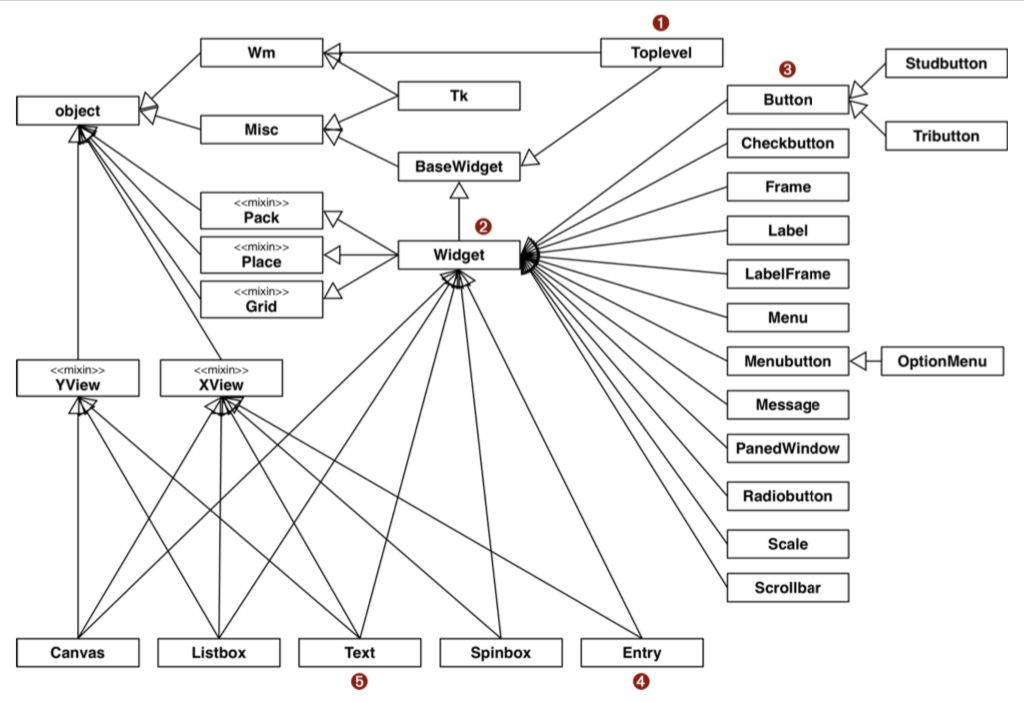

In [36]:
def print_mro(cls):
    print(', '.join(c.__name__ for c in cls.__mro__))

In [37]:
import tkinter
print_mro(tkinter.Toplevel)
print_mro(tkinter.Widget)
print_mro(tkinter.Button)
print_mro(tkinter.Entry)
print_mro(tkinter.Text)

Toplevel, BaseWidget, Misc, Wm, object
Widget, BaseWidget, Misc, Pack, Place, Grid, object
Button, Widget, BaseWidget, Misc, Pack, Place, Grid, object
Entry, Widget, BaseWidget, Misc, Pack, Place, Grid, XView, object
Text, Widget, BaseWidget, Misc, Pack, Place, Grid, XView, YView, object
